# ML for Bioinformatics
## Long short-term memory

---

Name: Sana Ayromlou


---

# ECG Heartbeat Classification

In this exercise you will implement an LSTM neural network that can classify ambulatory ECG recordings into 5 different classes. 

# Collect Data
We use a preprocessed version of a famous datasets in heartbeat classification, [the MIT-BIH Arrhythmia Dataset](https://physionet.org/content/mitdb/1.0.0/). 
The signals in this dataset correspond to electrocardiogram (ECG) shapes of heartbeats for the normal case and the cases affected by different arrhythmias and myocardial infarction. We will use the Arrhythmia Dataset used in [this paper](https://arxiv.org/abs/1805.00794) which is the preprocessed arrhythmia dataset consisting of signals that are preprocessed and segmented, with each segment corresponding to a heartbeat in the dataset. This dataset is composed of 109446 samples which are classified into 5 categories. You must download the dataset from [here](https://drive.google.com/file/d/1a8IetOZkvnq8D8K6k8EdMsFGeqE2Hv5M/view?usp=sharing). It is also accessible on [kaggle](https://www.kaggle.com/shayanfazeli/heartbeat).

The training and test data is located in mitbih_train.csv and mitbih_test.csv files. Locate these files in dataset folder next to this notebook. If you are running this notebook on colab, the following code does this phase.

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

FOLDERNAME = '/content/drive/My Drive/HW6'

# assert FOLDERNAME is not None, "[!] Enter the foldername."

# %cd drive/My\ Drive
# %cp -r $FOLDERNAME ../../
# %cd ../../
# %cd dataset
# !unzip 29414_37484_bundle_archive.zip
# !rm 29414_37484_bundle_archive.zip
# %cd ..
!cp '/content/drive/My Drive/HW6/29414_37484_bundle_archive.zip' .
!unzip -qq '29414_37484_bundle_archive.zip' -d . 

Mounted at /content/drive
replace ./mitbih_test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm, trange
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from IPython import display

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


# Create Custom Dataset
You need to create your custom dataset so you can define a dataloader to use in the train and test phase. Your class must implement init, getitem and len methods.

In [ ]:
file_path = '/content/mitbih_train.csv'
Train_Data = pd.read_csv(file_path,header=None)

In [ ]:
Train_Data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,0.044118,0.061275,0.066176,0.061275,0.049020,0.073529,0.061275,0.061275,0.066176,0.068627,0.095588,0.075980,0.093137,0.105392,0.115196,0.102941,0.117647,0.125000,0.142157,0.127451,0.151961,0.144608,0.164216,0.144608,0.159314,0.151961,0.154412,0.142157,0.151961,0.151961,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,0.074074,0.062678,0.065527,0.065527,0.062678,0.076923,0.071225,0.082621,0.091168,0.096866,0.082621,0.082621,0.091168,0.105413,0.122507,0.148148,0.182336,0.193732,0.213675,0.207977,0.222222,0.253561,0.270655,0.287749,0.284900,0.293447,0.256410,0.247863,0.188034,0.145299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,0.056757,0.043243,0.067568,0.062162,0.078378,0.072973,0.086486,0.081081,0.108108,0.110811,0.135135,0.135135,0.170270,0.183784,0.216216,0.237838,0.270270,0.286486,0.316216,0.318919,0.332432,0.297297,0.267568,0.216216,0.189189,0.132432,0.118919,0.064865,0.064865,0.043243,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,0.063536,0.082873,0.085635,0.093923,0.113260,0.124309,0.140884,0.132597,0.140884,0.091160,0.085635,0.074586,0.071823,0.080110,0.096685,0.118785,0.138122,0.140884,0.138122,0.146409,0.110497,0.102210,0.060773,0.027624,0.038674,0.013812,0.011050,0.013812,0.033149,0.005525,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,0.131455,0.122066,0.140845,0.159624,0.150235,0.145540,0.136150,0.169014,0.178404,0.173709,0.183099,0.201878,0.187793,0.164319,0.187793,0.215962,0.215962,0.201878,0.211268,0.230047,0.215962,0.230047,0.239437,0.267606,0.253521,0.230047,0.220657,0.225352,0.211268,0.173709,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
Train_Data.shape

(87554, 188)

In [ ]:
file_path = '/content/mitbih_test.csv'
Test_Data = pd.read_csv(file_path,header=None)

In [ ]:
Test_Data.shape[1]

188

In [ ]:
class HeartbeatDataset(Dataset):
    
    def __init__(self, csv_file):
        self.Data = pd.read_csv(file_path,header=None)
        self.X = Train_Data.values[:,0:self.Data.shape[1]-1]
        self.y = Train_Data.values[:,self.Data.shape[1]-1]
        pass

    def __getitem__(self, index):
        data = torch.from_numpy(self.X[index])
        label = torch.from_numpy(np.asarray(self.y[index]))
        sample = [data,label]
        return sample

    def __len__(self):
        return len(self.X)

batch_size = 64

train_set = HeartbeatDataset('/content/mitbih_test.csv')

train_targets = torch.from_numpy(train_set.y)
_, train_class_sample_counts = torch.unique(train_targets, sorted=True, return_counts=True)
train_weights = 100. / np.log(train_class_sample_counts.float())
train_samples_weights = train_weights[train_targets.long()]
train_sampler = WeightedRandomSampler(weights=train_samples_weights, num_samples=len(train_samples_weights), replacement=True)

train_loader = DataLoader(dataset=train_set,
                          batch_size=batch_size,sampler=train_sampler)                          

test_set = HeartbeatDataset('/content/mitbih_test.csv')
test_loader = DataLoader(dataset=test_set,
                        batch_size=batch_size,
                         shuffle=True)                         

In [ ]:
num_classes = 5
class_samples_num = [0 for i in range(num_classes)]
for data in train_loader:
    inputs, labels = data        
    for i in labels:
        class_samples_num[int(i)] += 1
print(class_samples_num)

[68596, 3018, 7044, 1076, 7820]


# Create LSTM Classifier
Now you are ready to implement your LSTM neural network which inherits from nn.Module. The structure of the network must be as follows:

  (lstm): LSTM(1, hidden_dim) <br>
  (fully_connected): Linear(in_features=hidden_dim, out_features=middle_dim, bias=True) <br>
  (fully_connected): Linear(in_features=middle_dim, out_features=5, bias=True) <br>
  (softmax): Softmax(dim=1)
)

At each step the value of signal is given as input to the LSTM block. The hidden state and cell state get updated and the final output is computed by two fully connected after the final hidden state with a softmax layer at the end.



In [ ]:
class LSTMClassifier(nn.Module):

    def __init__(self, input_dim, hidden_dim, fc_dim, target_dim):
        super(LSTMClassifier, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.fc_dim = fc_dim
        self.target_dim = target_dim
        self.batch_size = batch_size
        
 
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, batch_first=True)
        self.linear1 = nn.Linear(self.hidden_dim, self.fc_dim, bias=True)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(self.fc_dim, self.target_dim, bias=True)

    def forward(self, x):

        # print(x.unsqueeze(2).shape)
        lstm_out, self.hidden = self.lstm(x.unsqueeze(2))
        out = self.linear1(lstm_out[:,-1,:])
        out = self.relu(out)
        out = self.linear2(out)
        return out

# Define loss function and optimizer
Next you can instance a classifier, loss function and optimizer. You are free to change the loss function, the optimizer and their parameters along with dimensions of the hidden state and the fully connected layer of the classifier.

In [ ]:
lstm_classifier = LSTMClassifier(1, 64, 32, 5)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_classifier.parameters(), lr=0.01)
print(lstm_classifier)

lstm_classifier = LSTMClassifier(1, 64, 32, num_classes)
lstm_classifier.to(device)
print(lstm_classifier)
loss_weight = torch.from_numpy((1/np.array(class_samples_num))/sum(1/np.array(class_samples_num))).float()
print(loss_weight)
criterion = nn.CrossEntropyLoss(weight=loss_weight)
criterion.to(device)
optimizer = torch.optim.Adam(lstm_classifier.parameters())

LSTMClassifier(
  (lstm): LSTM(1, 64, batch_first=True)
  (linear1): Linear(in_features=64, out_features=32, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=32, out_features=5, bias=True)
)
LSTMClassifier(
  (lstm): LSTM(1, 64, batch_first=True)
  (linear1): Linear(in_features=64, out_features=32, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=32, out_features=5, bias=True)
)
tensor([0.0094, 0.2144, 0.0919, 0.6015, 0.0828])


# Train the classifier
The following code runs the training phase using what you have build so far. You can edit the code.

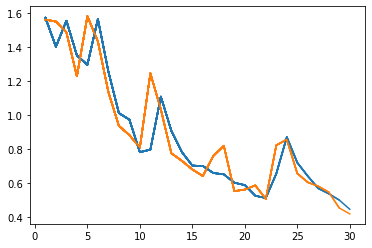

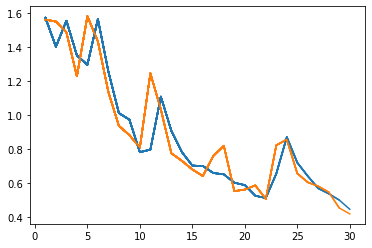

In [ ]:
from tqdm import tqdm
epoch_num = 30

train_log = []
test_log = []

for epoch in range(1, epoch_num+1):
    running_loss = 0    
    train_loss = []
    lstm_classifier.train()
    for (inputs, labels) in tqdm(train_loader, desc='Training epoch ' + str(epoch), leave=False):        
        inputs, labels = inputs.to(device), labels.to(device)        
        optimizer.zero_grad()
        outputs = lstm_classifier(inputs.float())          
        loss = criterion(outputs, labels.long())        
        loss.backward()                
        optimizer.step()        
        train_loss.append(loss.item())
    train_log.append(np.mean(train_loss))

    running_loss = 0
    test_loss = []
    lstm_classifier.eval()
    with torch.no_grad():                
        for (inputs, labels) in tqdm(test_loader, desc='Test', leave=False):         
            inputs, labels = inputs.to(device), labels.to(device)        
            outputs = lstm_classifier(inputs.float())                       
            loss = criterion(outputs, labels.long())            
            test_loss.append(loss.item())
    test_log.append(np.mean(test_loss))    
    plt.plot(range(1, epoch+1), train_log, color='C0')
    plt.plot(range(1, epoch+1), test_log, color='C1')
    display.clear_output(wait=True)
    display.display(plt.gcf())

# Test the classifier
The following code runs the LSTM classifier on test data and reports the results for each class.

In [ ]:
y_true = []
y_pred = []
with torch.no_grad():
    lstm_classifier.eval()
    for (inputs, labels) in tqdm(test_loader, desc='Test'):         
        inputs, labels = inputs.to(device), labels.to(device)        
        outputs = lstm_classifier(inputs.float())                       
        y_true += torch.eye(num_classes)[labels.long()].tolist()
        y_pred += outputs.tolist()
y_true = np.array(y_true)
y_pred = np.array(y_pred)
print('ROC_AUC Score:', roc_auc_score(y_true, y_pred))
print(classification_report(y_true.argmax(axis=1), y_pred.argmax(axis=1)))



Test:   0%|          | 0/1369 [00:00<?, ?it/s]

Test:   1%|          | 8/1369 [00:00<00:18, 73.67it/s]

Test:   1%|          | 16/1369 [00:00<00:18, 74.13it/s]

Test:   2%|▏         | 24/1369 [00:00<00:17, 75.55it/s]

Test:   2%|▏         | 32/1369 [00:00<00:17, 76.64it/s]

Test:   3%|▎         | 40/1369 [00:00<00:17, 77.41it/s]

Test:   4%|▎         | 48/1369 [00:00<00:16, 77.94it/s]

Test:   4%|▍         | 57/1369 [00:00<00:16, 78.63it/s]

Test:   5%|▍         | 65/1369 [00:00<00:16, 78.54it/s]

Test:   5%|▌         | 73/1369 [00:00<00:16, 78.60it/s]

Test:   6%|▌         | 81/1369 [00:01<00:16, 78.89it/s]

Test:   7%|▋         | 90/1369 [00:01<00:16, 79.24it/s]

Test:   7%|▋         | 98/1369 [00:01<00:16, 79.38it/s]

Test:   8%|▊         | 107/1369 [00:01<00:15, 79.61it/s]

Test:   8%|▊         | 115/1369 [00:01<00:15, 79.71it/s]

Test:   9%|▉         | 124/1369 [00:01<00:15, 79.86it/s]

Test:  10%|▉         | 132/1369 [00:01<00:15, 78.98it/s]

Test:  10%|█         | 140/1369 [00

ROC_AUC Score: 0.9513916173808937
              precision    recall  f1-score   support

           0       0.98      0.84      0.91     72471
           1       0.20      0.78      0.32      2223
           2       0.70      0.87      0.78      5788
           3       0.16      0.90      0.27       641
           4       0.94      0.92      0.93      6431

    accuracy                           0.85     87554
   macro avg       0.60      0.86      0.64     87554
weighted avg       0.94      0.85      0.88     87554



# Useful Links and Acknowledgements

[An Effective LSTM Recurrent Network to Detect Arrhythmia on Imbalanced ECG Dataset](https://www.hindawi.com/journals/jhe/2019/6320651/)

[Classify ECG Signals Using Long Short-Term Memory Networks
](https://https://www.mathworks.com/help/signal/examples/classify-ecg-signals-using-long-short-term-memory-networks.html)

[Sequence Models and Long-Short Term Memory Networks](https://https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html)

[LSTMs for Time Series in PyTorch](https://www.jessicayung.com/lstms-for-time-series-in-pytorch/)

[ECG Heartbeat Classification: A Deep Transferable Representation
](https://https://arxiv.org/abs/1805.00794)

[MIT-BIH Arrhythmia Database](https://https://physionet.org/content/mitdb/1.0.0/)